In random forests, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.

Furthermore, when splitting each node during the construction of a tree, the best split is found through an exhaustive search of the features values of either all input features or a random subset of size max_features. Default for max_features is sqrt.

The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.

The scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

Scikit allows for parallel computation in fitting forests.

The relative rank (i.e. depth) of a feature used as a decision node in a tree can be used to assess the relative importance of that feature with respect to the predictability of the target variable. Features used at the top of the tree contribute to the final prediction decision of a larger fraction of the input samples. The expected fraction of the samples they contribute to can thus be used as an estimate of the relative importance of the features. In scikit-learn, the fraction of samples a feature contributes to is combined with the decrease in impurity from splitting them to create a normalized estimate of the predictive power of that feature.

By averaging the estimates of predictive ability over several randomized trees one can reduce the variance of such an estimate and use it for feature selection. This is known as the mean decrease in impurity, or MDI. Refer to [L2014] for more information on MDI and feature importance evaluation with Random Forests.

The impurity-based feature importances computed on tree-based models suffer from two flaws that can lead to misleading conclusions. First they are computed on statistics derived from the training dataset and therefore do not necessarily inform us on which features are most important to make good predictions on held-out dataset. Secondly, they favor high cardinality features, that is features with many unique values. Permutation feature importance is an alternative to impurity-based feature importance that does not suffer from these flaws. These two methods of obtaining feature importance are explored in: Permutation Importance vs Random Forest Feature Importance (MDI).

In practice those estimates are stored as an attribute named feature_importances_ on the fitted model. This is an array with shape (n_features,) whose values are positive and sum to 1.0. The higher the value, the more important is the contribution of the matching feature to the prediction function.

# Dataset

Датасет [ссылка](https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset)

В нем есть GPA и GradeClass, оба этих столбца это оценка, но GPA это вещественное значение, которое можно использовать для регрессии, а GradeClass можно использовать для классфикации.

В нем нет пропусков данных.

In [1]:
import pandas as pd

In [172]:
df = pd.read_csv("student_performance.csv")

In [173]:
len(df)

2392

In [174]:
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


# Classification

Первое, что мы сделаем, будет классификация

In [175]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [176]:
df_class = df.drop(columns=["Ethnicity", "StudentID", "GPA"])

In [177]:
X = df_class.drop(["GradeClass"], axis=1)
y = df_class["GradeClass"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [135]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [136]:
from sklearn.metrics import classification_report

In [137]:
y_pred = rf.predict(X_test)
print("Score", rf.score(X_test, y_test))

Score 0.7423398328690808


In [138]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.60      0.18      0.27        34
         1.0       0.47      0.49      0.48        69
         2.0       0.59      0.59      0.59       117
         3.0       0.58      0.55      0.56       117
         4.0       0.88      0.94      0.91       381

    accuracy                           0.74       718
   macro avg       0.62      0.55      0.56       718
weighted avg       0.73      0.74      0.73       718



In [139]:
features = pd.DataFrame(rf.feature_importances_, index=X_test.columns)
print(features.head(15))

                          0
Age                0.062034
Gender             0.030616
ParentalEducation  0.063812
StudyTimeWeekly    0.187782
Absences           0.459082
Tutoring           0.028555
ParentalSupport    0.069870
Extracurricular    0.027325
Sports             0.028567
Music              0.022173
Volunteering       0.020183


## Out of Bag

How many out-of-bag were correct

In [140]:
rf = RandomForestClassifier(
    oob_score=True,
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Score", rf.score(X_test, y_test))
print("OOB", rf.oob_score_)

Score 0.713091922005571
OOB 0.6959378733572282


## Custom Parameters

Теперь попробуем классификацию с кастомными параметрами

The main parameters to adjust when using these methods is n_estimators and max_features. The former is the number of trees in the forest. The larger the better, but also the longer it will take to compute. In addition, note that results will stop getting significantly better beyond a critical number of trees. The latter is the size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias. Empirical good default values are max_features=1.0 or equivalently max_features=None (always considering all features instead of a random subset) for regression problems, and max_features="sqrt" (using a random subset of size sqrt(n_features)) for classification tasks (where n_features is the number of features in the data). The default value of max_features=1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values (e.g. 0.3 is a typical default in the literature). Good results are often achieved when setting max_depth=None in combination with min_samples_split=2 (i.e., when fully developing the trees). Bear in mind though that these values are usually not optimal, and might result in models that consume a lot of RAM. The best parameter values should always be cross-validated. In addition, note that in random forests, bootstrap samples are used by default (bootstrap=True) while the default strategy for extra-trees is to use the whole dataset (bootstrap=False). When using bootstrap sampling the generalization error can be estimated on the left out or out-of-bag samples. This can be enabled by setting oob_score=True.

The size of the model with the default parameters is O(M N log N), where M is the number of trees and N is the number of samples. In order to reduce the size of the model, you can change these parameters: min_samples_split, max_leaf_nodes, max_depth and min_samples_leaf.

In [141]:
rf = RandomForestClassifier(
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=1,
)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [142]:
y_pred = rf.predict(X_test)
print("Score", rf.score(X_test, y_test))

Score 0.7298050139275766


In [143]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.18      0.29        34
         1.0       0.44      0.48      0.46        69
         2.0       0.56      0.56      0.56       117
         3.0       0.54      0.52      0.53       117
         4.0       0.88      0.94      0.91       381

    accuracy                           0.73       718
   macro avg       0.64      0.53      0.55       718
weighted avg       0.73      0.73      0.72       718



In [145]:
features = pd.DataFrame(rf.feature_importances_, index=X_test.columns)
features = features.sort_values(by=[0])
print(features)

                          0
Volunteering       0.021358
Music              0.021450
Tutoring           0.026411
Extracurricular    0.028604
Sports             0.029552
Gender             0.030294
Age                0.062766
ParentalEducation  0.064260
ParentalSupport    0.071299
StudyTimeWeekly    0.184468
Absences           0.459537


In [185]:
feats = []
scores = []
n = 10
for i in range(1, n+1):
    max_features = i/n
    rf = RandomForestClassifier(
        n_estimators=100,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=max_features,
    )
    rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    feats.append(max_features)
    scores.append(score)

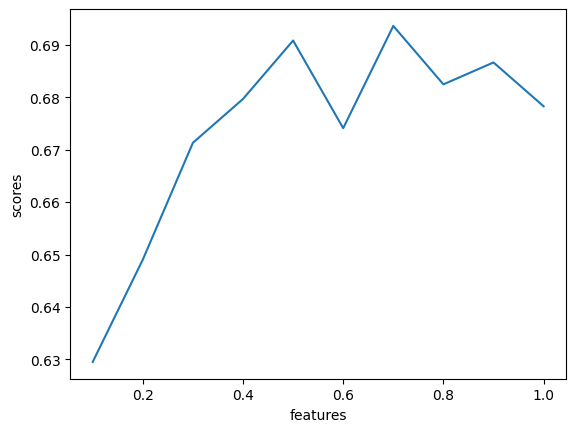

In [186]:
import matplotlib.pyplot as plt
plt.plot(feats, scores)
plt.xlabel('features')
plt.ylabel('scores')
plt.show()

## Classification Forest vs Tree

In [79]:
from sklearn.tree import DecisionTreeClassifier

In [80]:
dt = DecisionTreeClassifier(
    min_samples_split=20,
    min_samples_leaf=6,
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=6, min_samples_split=20)

In [81]:
y_pred = dt.predict(X_test)
print("Score", dt.score(X_test, y_test))

Score 0.6908077994428969


In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.13      0.08      0.10        26
         1.0       0.41      0.44      0.43        75
         2.0       0.51      0.51      0.51       113
         3.0       0.53      0.42      0.47       123
         4.0       0.85      0.92      0.89       381

    accuracy                           0.69       718
   macro avg       0.49      0.47      0.48       718
weighted avg       0.67      0.69      0.68       718



In [83]:
features = pd.DataFrame(dt.feature_importances_, index=X_test.columns)
features = features.sort_values(by=[0])
print(features)

                          0
Age                0.019737
Gender             0.005372
ParentalEducation  0.011268
StudyTimeWeekly    0.130560
Absences           0.657912
Tutoring           0.035700
ParentalSupport    0.064313
Extracurricular    0.021295
Sports             0.026778
Music              0.018809
Volunteering       0.008259


### Overfit Tree

In [146]:
dt = DecisionTreeClassifier(
    min_samples_split=2,
    min_samples_leaf=1,
)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Score", dt.score(X_test, y_test))
print(classification_report(y_test, y_pred))
features = pd.DataFrame(dt.feature_importances_, index=X_test.columns)
features = features.sort_values(by=[0])
print(features)

Score 0.6350974930362117
              precision    recall  f1-score   support

         0.0       0.15      0.15      0.15        34
         1.0       0.31      0.36      0.33        69
         2.0       0.48      0.51      0.49       117
         3.0       0.43      0.37      0.40       117
         4.0       0.85      0.85      0.85       381

    accuracy                           0.64       718
   macro avg       0.44      0.45      0.44       718
weighted avg       0.64      0.64      0.64       718

                          0
Volunteering       0.019895
Extracurricular    0.023476
Music              0.024564
Gender             0.025237
Tutoring           0.035884
Sports             0.041239
Age                0.047047
ParentalEducation  0.058702
ParentalSupport    0.081749
StudyTimeWeekly    0.225791
Absences           0.416416


# Regression

Теперь посмотрим на регрессию

In [189]:
df_regr = df.drop(columns=["Ethnicity", "StudentID", "GradeClass"])

In [190]:
X = df_regr.drop(["GPA"], axis=1)
y = df_regr["GPA"]

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [155]:
from sklearn.ensemble import RandomForestRegressor

In [168]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=0.3)

In [169]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

In [170]:
y_pred = rf.predict(X_test)
print("Score", rf.score(X_test, y_test))
print("MAE", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("R2", r2_score(y_test, y_pred))

Score 0.9142706121223092
MAE 0.21185770566204887
MSE 0.07069566525622284
R2 0.9142706121223092


In [92]:
features = pd.DataFrame(rf.feature_importances_, index=X_test.columns)
print(features.head(15))

                          0
Age                0.007424
Gender             0.003253
ParentalEducation  0.006950
StudyTimeWeekly    0.059393
Absences           0.849812
Tutoring           0.014328
ParentalSupport    0.037448
Extracurricular    0.008666
Sports             0.006930
Music              0.003903
Volunteering       0.001893


In [192]:
feats = []
scores = []
n = 10
for i in range(1, n+1):
    max_features = i/n
    rf = RandomForestRegressor(
        n_estimators=300,
        min_samples_split=20,
        min_samples_leaf=6,
        max_features=max_features
    )
    rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    feats.append(max_features)
    scores.append(score)

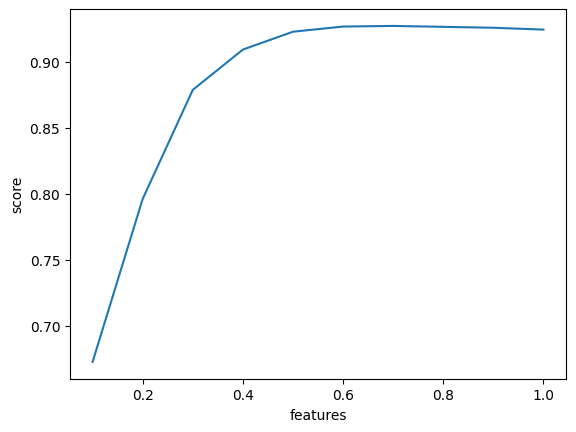

In [194]:
import matplotlib.pyplot as plt
plt.plot(feats, scores)
plt.xlabel('features')
plt.ylabel('score')
plt.show()

## GridSearch

Теперь посмотрим на подбор гиперпараметров с помощью кросс-валидации

In [93]:
from sklearn.model_selection import GridSearchCV

In [33]:
param_grid = {
    #"n_estimators": [100, 300, 600],
    #"max_depth": [20, 30],
    "min_samples_split": [15, 20, 25],
    "min_samples_leaf": [3, 6, 10],
    #"criterion": ["squared_error", "friedman_mse", "poisson"],
}

In [151]:
rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_split=20,
    min_samples_leaf=6,
)
rf_cv = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=3, 
    scoring="neg_mean_squared_error",
    verbose=3,
)

In [148]:
rf_cv.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=15;, score=-0.556 total time=   0.3s
[CV 2/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=15;, score=-0.567 total time=   0.3s
[CV 3/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=15;, score=-0.528 total time=   0.3s
[CV 1/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=20;, score=-0.571 total time=   0.3s
[CV 2/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=20;, score=-0.580 total time=   0.3s
[CV 3/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=20;, score=-0.528 total time=   0.3s
[CV 1/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=25;, score=-0.574 total time=   0.3s
[CV 2/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=25;, score=-0.589 total time=   0.3s
[CV 3/3] END criterion=squared_erro

GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_features=0.3,
                                             min_samples_leaf=6,
                                             min_samples_split=20,
                                             n_estimators=300),
             param_grid={'criterion': ['squared_error', 'poisson'],
                         'min_samples_leaf': [3, 6, 10],
                         'min_samples_split': [15, 20, 25]},
             scoring='neg_mean_squared_error', verbose=3)

In [149]:
print("Best Estimator", rf_cv.best_params_)

Best Estimator {'criterion': 'squared_error', 'min_samples_leaf': 3, 'min_samples_split': 15}


In [150]:
y_pred = rf_cv.predict(X_test)
print("Score", rf_cv.score(X_test, y_test))
print("MAE", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("R2", r2_score(y_test, y_pred))

Score -0.5490646809207534
MAE 0.49752681782619146
MSE 0.5490646809207534
R2 0.6347023212241238


In [38]:
rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_split=20,
    min_samples_leaf=6,
    criterion="squared_error",
)
rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=6, min_samples_split=20,
                      n_estimators=300)

In [39]:
y_pred = rf.predict(X_test)
print("Score", rf.score(X_test, y_test))
print("MAE", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("R2", r2_score(y_test, y_pred))

Score 0.9233486541448092
MAE 0.20255754483101526
MSE 0.06313249071060838
R2 0.9233486541448092


## Regression Forest vs Tree

Сравнение с деревьями

In [94]:
from sklearn.tree import DecisionTreeRegressor

In [95]:
dt = DecisionTreeRegressor(
    min_samples_split=20,
    min_samples_leaf=10,
)
dt.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_leaf=10, min_samples_split=20)

In [42]:
y_pred = dt.predict(X_test)
print("Score", dt.score(X_test, y_test))
print("MAE", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("R2", r2_score(y_test, y_pred))

Score 0.8943098284153485
MAE 0.23588375584011176
MSE 0.08704979281611351
R2 0.8943098284153485


### GridSearch

In [43]:
param_grid = {
    "min_samples_split": [15, 20, 25],
    "min_samples_leaf": [3, 6, 10],
    "criterion": ["squared_error", "poisson"],
}

In [44]:
dt = DecisionTreeRegressor()
dt_cv = GridSearchCV(
    estimator=dt, 
    param_grid=param_grid, 
    cv=3, 
    scoring="neg_mean_squared_error",
    verbose=3,
)

In [45]:
dt_cv.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=15;, score=-0.087 total time=   0.0s
[CV 2/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=15;, score=-0.095 total time=   0.0s
[CV 3/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=15;, score=-0.103 total time=   0.0s
[CV 1/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=20;, score=-0.090 total time=   0.0s
[CV 2/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=20;, score=-0.097 total time=   0.0s
[CV 3/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=20;, score=-0.105 total time=   0.0s
[CV 1/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=25;, score=-0.092 total time=   0.0s
[CV 2/3] END criterion=squared_error, min_samples_leaf=3, min_samples_split=25;, score=-0.096 total time=   0.0s
[CV 3/3] END criterion=squared_erro

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'poisson'],
                         'min_samples_leaf': [3, 6, 10],
                         'min_samples_split': [15, 20, 25]},
             scoring='neg_mean_squared_error', verbose=3)

In [46]:
print("Best Estimator", dt_cv.best_params_)

Best Estimator {'criterion': 'squared_error', 'min_samples_leaf': 6, 'min_samples_split': 15}


In [47]:
y_pred = dt_cv.predict(X_test)
print("Score", dt_cv.score(X_test, y_test))
print("MAE", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("R2", r2_score(y_test, y_pred))

Score -0.08811750896766084
MAE 0.23551106594240337
MSE 0.08811750896766084
R2 0.8930134772166831


### Overfit Tree

In [96]:
dt = DecisionTreeRegressor(
    min_samples_split=2,
    min_samples_leaf=1,
)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Score", dt.score(X_test, y_test))
print("MAE", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("R2", r2_score(y_test, y_pred))

Score 0.8460811912090351
MAE 0.27505543195590115
MSE 0.12372270944149827
R2 0.8460811912090351


# Dataset Gym

[ссылка](https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset)

In [106]:
df = pd.read_csv("gym_members.csv")
len(df)

973

In [109]:
df['Gender'] = df['Gender'].replace({'Female': '0', 'Male': '1'}).infer_objects(copy=False)

In [110]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

In [111]:
df = encode_and_bind(df, "Workout_Type")

In [112]:
df.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Workout_Type_Cardio,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga
0,56,1,88.3,1.71,180,157,60,1.69,1313.0,12.6,3.5,4,3,30.20,False,False,False,True
1,46,0,74.9,1.53,179,151,66,1.30,883.0,33.9,2.1,4,2,32.00,False,True,False,False
2,32,0,68.1,1.66,167,122,54,1.11,677.0,33.4,2.3,4,2,24.71,True,False,False,False
3,25,1,53.2,1.70,190,164,56,0.59,532.0,28.8,2.1,3,1,18.41,False,False,True,False
4,38,1,46.1,1.79,188,158,68,0.64,556.0,29.2,2.8,3,1,14.39,False,False,True,False


In [113]:
df_class = df.drop(columns=[])

In [114]:
X = df_class.drop(["Gender"], axis=1)
y = df_class["Gender"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Random Forest

In [115]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [116]:
y_pred = rf.predict(X_test)
print("Score", rf.score(X_test, y_test))

Score 0.9794520547945206


In [117]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       127
           1       1.00      0.96      0.98       165

    accuracy                           0.98       292
   macro avg       0.98      0.98      0.98       292
weighted avg       0.98      0.98      0.98       292



In [118]:
features = pd.DataFrame(rf.feature_importances_, index=X_test.columns)
print(features)

                                      0
Age                            0.011565
Weight (kg)                    0.218445
Height (m)                     0.158987
Max_BPM                        0.017058
Avg_BPM                        0.013996
Resting_BPM                    0.011774
Session_Duration (hours)       0.034190
Calories_Burned                0.021002
Fat_Percentage                 0.132808
Water_Intake (liters)          0.302231
Workout_Frequency (days/week)  0.007542
Experience_Level               0.011224
BMI                            0.050836
Workout_Type_Cardio            0.002557
Workout_Type_HIIT              0.001555
Workout_Type_Strength          0.002641
Workout_Type_Yoga              0.001587


## Decision Tree

In [119]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [120]:
y_pred = dt.predict(X_test)
print("Score", dt.score(X_test, y_test))

Score 0.958904109589041


In [121]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       127
           1       0.98      0.95      0.96       165

    accuracy                           0.96       292
   macro avg       0.96      0.96      0.96       292
weighted avg       0.96      0.96      0.96       292



In [122]:
features = pd.DataFrame(dt.feature_importances_, index=X_test.columns)
features = features.sort_values(by=[0])
print(features)

                                      0
Age                            0.000000
Workout_Type_Cardio            0.000000
Workout_Type_Strength          0.000000
Workout_Type_HIIT              0.000000
BMI                            0.000000
Experience_Level               0.000000
Workout_Frequency (days/week)  0.000000
Workout_Type_Yoga              0.000000
Max_BPM                        0.002779
Avg_BPM                        0.004628
Resting_BPM                    0.007974
Calories_Burned                0.012778
Session_Duration (hours)       0.036801
Fat_Percentage                 0.082649
Height (m)                     0.083851
Weight (kg)                    0.220246
Water_Intake (liters)          0.548295


### Overfit Tree

In [128]:
dt = DecisionTreeClassifier(
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=10000,
)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Score", dt.score(X_test, y_test))
print(classification_report(y_test, y_pred))
features = pd.DataFrame(dt.feature_importances_, index=X_test.columns)
features = features.sort_values(by=[0])
print(features)

Score 0.9383561643835616
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       127
           1       0.95      0.94      0.95       165

    accuracy                           0.94       292
   macro avg       0.94      0.94      0.94       292
weighted avg       0.94      0.94      0.94       292

                                      0
Age                            0.000000
Resting_BPM                    0.000000
Workout_Frequency (days/week)  0.000000
Workout_Type_HIIT              0.000000
BMI                            0.000000
Workout_Type_Cardio            0.000000
Experience_Level               0.000000
Workout_Type_Yoga              0.000000
Avg_BPM                        0.001690
Workout_Type_Strength          0.005036
Max_BPM                        0.007815
Calories_Burned                0.032182
Session_Duration (hours)       0.038480
Fat_Percentage                 0.078073
Height (m)                     0.080913
Weight (